In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
pip install fancyimpute

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import numpy as np
import pandas as pd
from six import StringIO
import os

from scipy import stats
import graphviz
import random

import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

from scipy.io import arff

import missingno as msno
import fancyimpute
from sklearn.impute import SimpleImputer

import sklearn
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import export_graphviz

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import precision_recall_curve



import tensorflow as tf
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras import layers
#from tensorflow.python.keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier

In [8]:
print(np.__version__) #1.20.1\
print(pd.__version__) #1.3.3\
print(plt.__version__) #1.20.1\
print(fancyimpute.__version__) #0.7.0\
print(sklearn.__version__) #1.2.0\
print(xgb.__version__) #1.3.3\

1.21.6
1.3.5
1.21.6
0.7.0
1.0.2
0.90


# Load and describe data

In [9]:
def load_arff_raw_data():
    N=5
    return [arff.loadarff('/content/drive/MyDrive/' + str(i+1) + 'year.arff') for i in range(N)]

############################################################
# Loads the 5 raw .arff files into pandas dataframes
def load_dataframes():
    return [pd.DataFrame(data_i_year[0]) for data_i_year in load_arff_raw_data()]

############################################################
# Set the column headers from X1 ... X64 and the class label as Y, for all the 5 dataframes.
def set_new_headers(dataframes):
    cols = ['X' + str(i+1) for i in range(len(dataframes[0].columns)-1)]
    cols.append('Y')
    for df in dataframes:
        df.columns = cols

############################################################
# dataframes is the list of pandas dataframes for the 5 year datafiles.  
dataframes = load_dataframes()

# Set the new headers for the dataframes. The new headers will have the renamed set of feature (X1 to X64)
set_new_headers(dataframes)    

# print the first 5 rows of a dataset 'year1'
dataframes[0].head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Y
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,b'0'
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,b'0'
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,b'0'
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,b'0'
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,b'0'


In [6]:
class describe_data:
    def setdf(self,df):
        self.df=df
        self.df1=pd.DataFrame(columns=['nrow', "ncol", 'Y=1cnt', 'Y=1rate',
                                       'rmisscnt', 'cmisscnt',
                                       'rmissrate','cmissrate'])
    def describe1(self):
        self.df1.loc[0,'nrow']=self.df.shape[0]
        self.df1['ncol']=self.df.shape[1]
        self.df1['Y=1cnt']=self.df[self.df['Y']==1].shape[0]
        self.df1['rmisscnt']= self.df[self.df.isnull().any(axis=1)==True].shape[0]
        self.df1['cmisscnt']= self.df.isnull().any().sum()
        self.df1['Y=1rate']= self.df1['Y=1cnt']/self.df1['nrow']
        self.df1['rmissrate']= self.df1['rmisscnt']/self.df1['nrow']
        self.df1['cmissrate']= self.df1['cmisscnt']/(self.df1['ncol']-1)
      
        return self.df1
    
    def checkmissing(self):
        missing_df = self.df.columns[self.df.isnull().any()].tolist()
        msno.matrix(self.df[missing_df], figsize=(20,5))
        
    def checkoutlier(self):
        train_describe_max = self.df.describe().loc['max',:]
        train_describe_min =  self.df.describe().loc['min',:]
        extreme_cols = train_describe_max[train_describe_max>4000].index.values
        extreme_cols=np.append(extreme_cols,(train_describe_max[train_describe_min<-8000].index.values))
        regular_cols = [col for col in  self.df.columns[:-1] if col not in extreme_cols]
        f, ax = plt.subplots(figsize=(10, 10))
        self.df.loc[:,extreme_cols].boxplot()
        f, ax = plt.subplots(figsize=(10, 10))
        self.df.loc[:,regular_cols].boxplot()
        
    def checkcorrelation(self):
        sns.set(style="white")
        corr = self.df.corr()
        f, ax = plt.subplots(figsize=(18, 18))
        cmap = sns.diverging_palette(220, 10, as_cmap=True)
        sns.heatmap(corr, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
        plt.show()

   nrow  ncol  Y=1cnt Y=1rate  rmisscnt  cmisscnt rmissrate  cmissrate
0  7027    65       0     0.0      3833        49  0.545467   0.765625


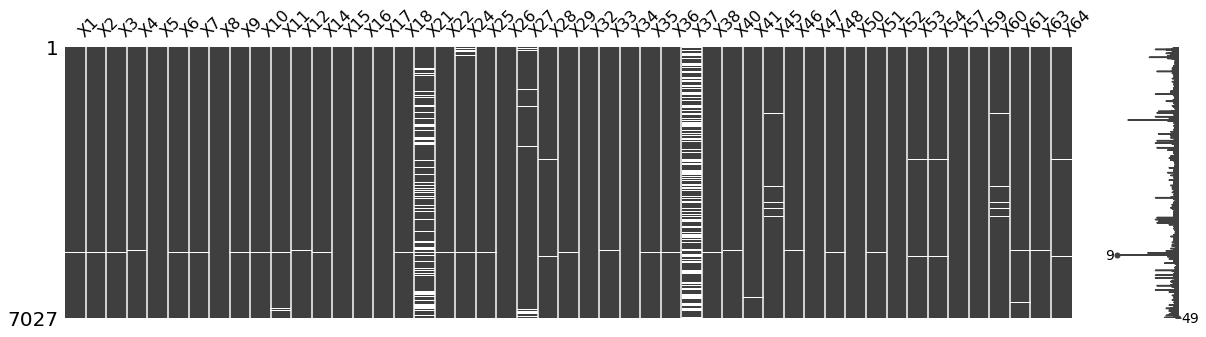

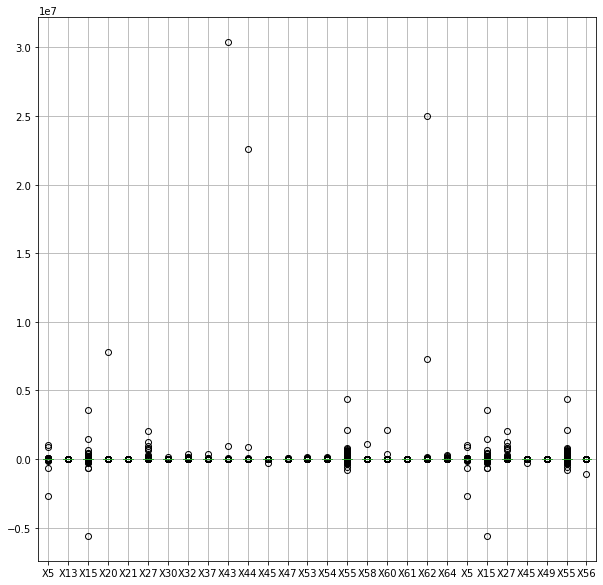

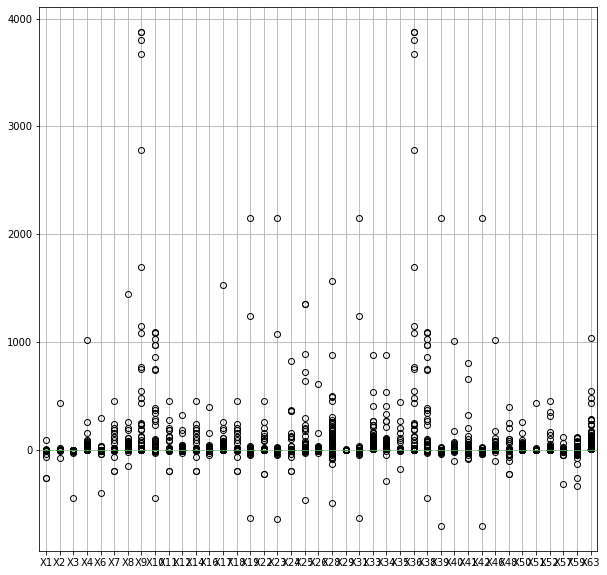

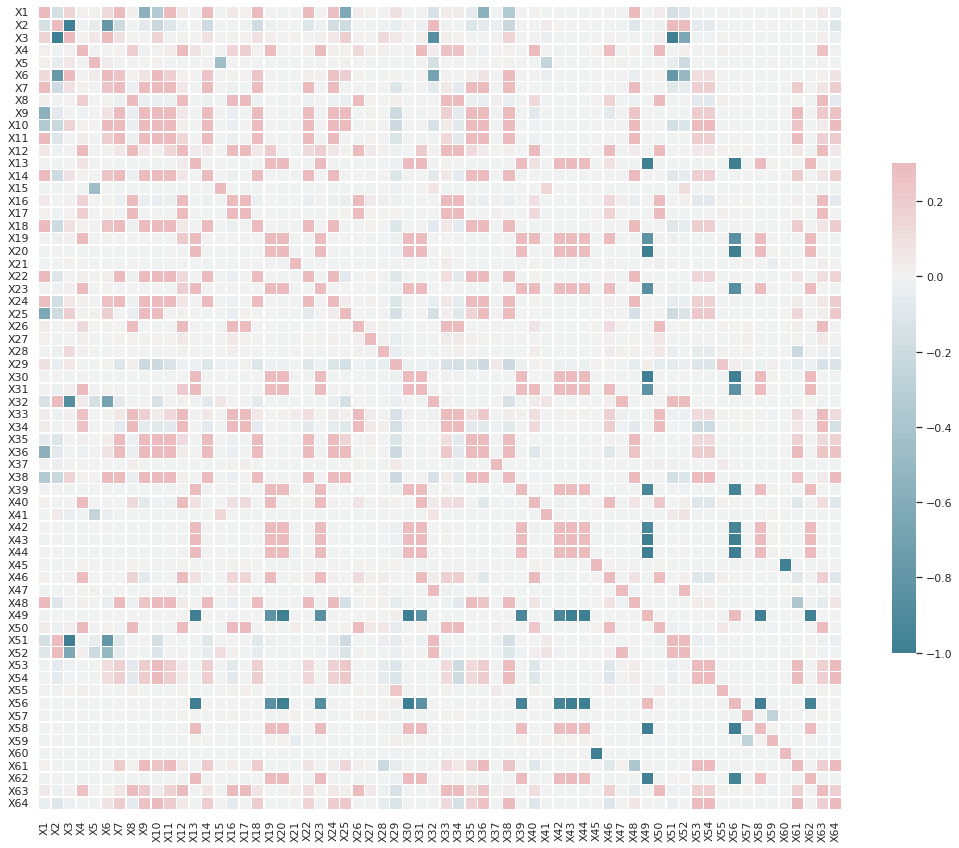

    nrow  ncol  Y=1cnt Y=1rate  rmisscnt  cmisscnt rmissrate  cmissrate
0  10173    65       0     0.0      6085        64  0.598152        1.0


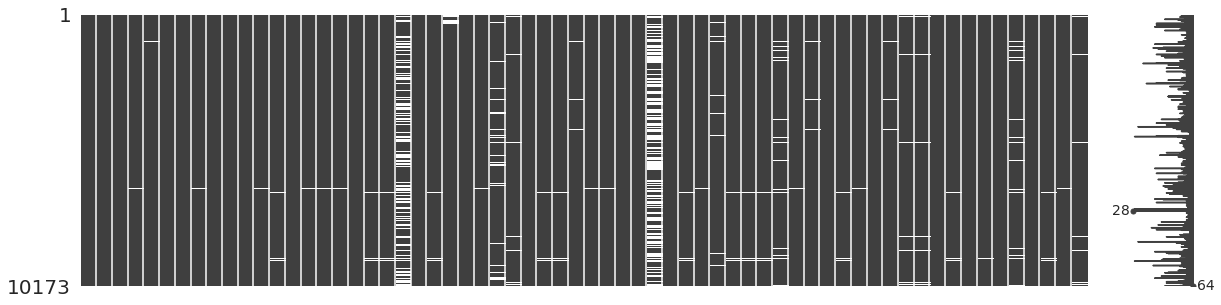

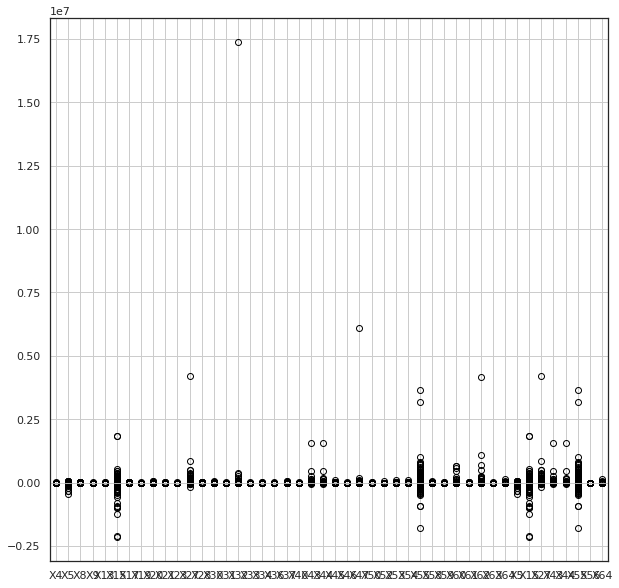

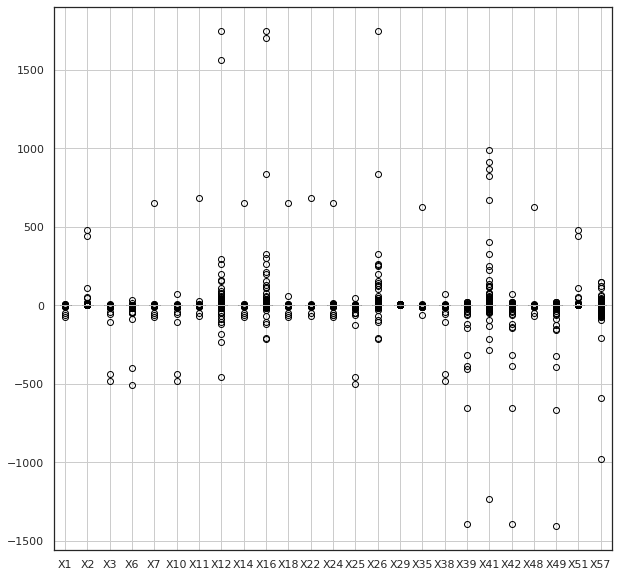

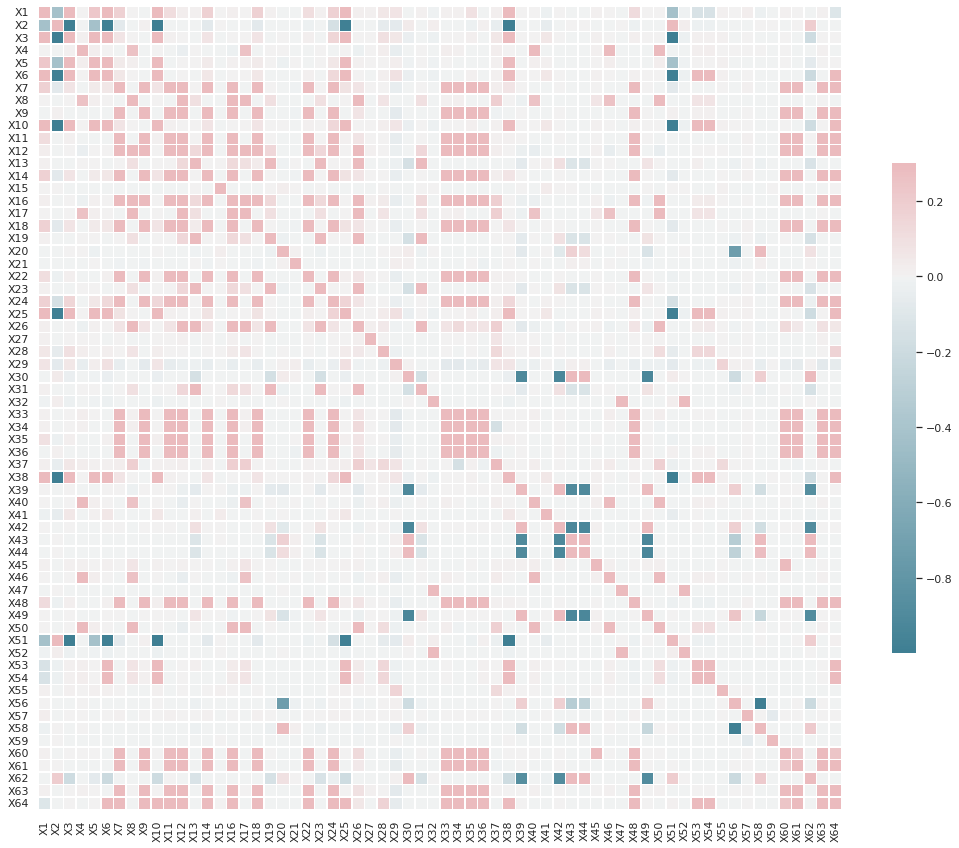

    nrow  ncol  Y=1cnt Y=1rate  rmisscnt  cmisscnt rmissrate  cmissrate
0  10503    65       0     0.0      5618        44  0.534895     0.6875


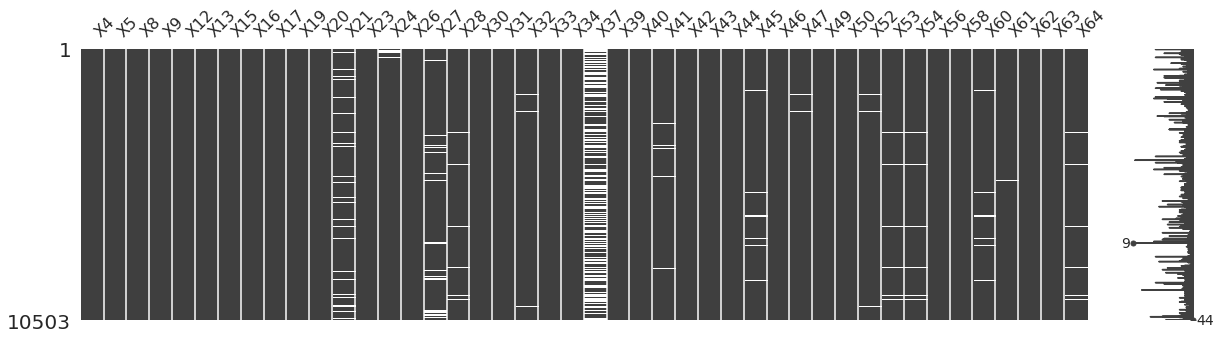

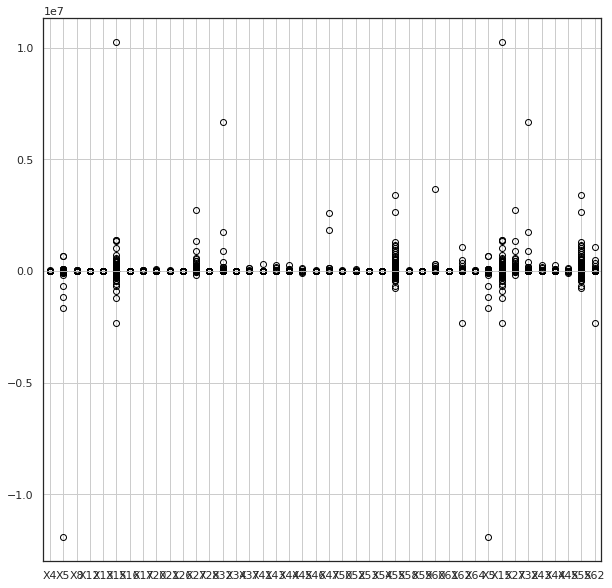

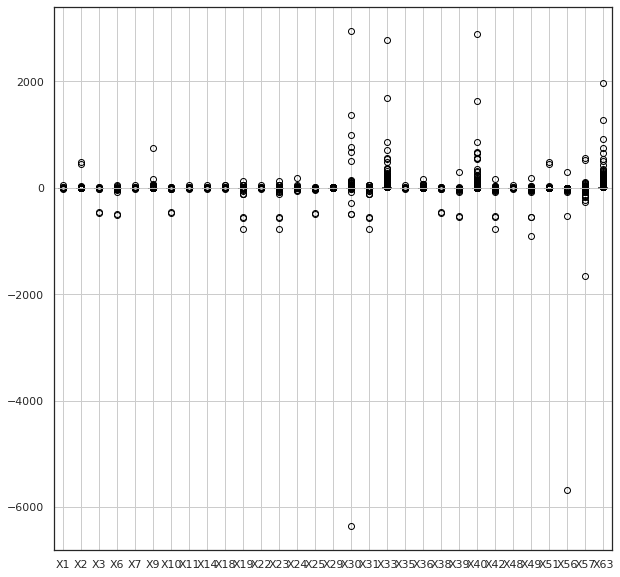

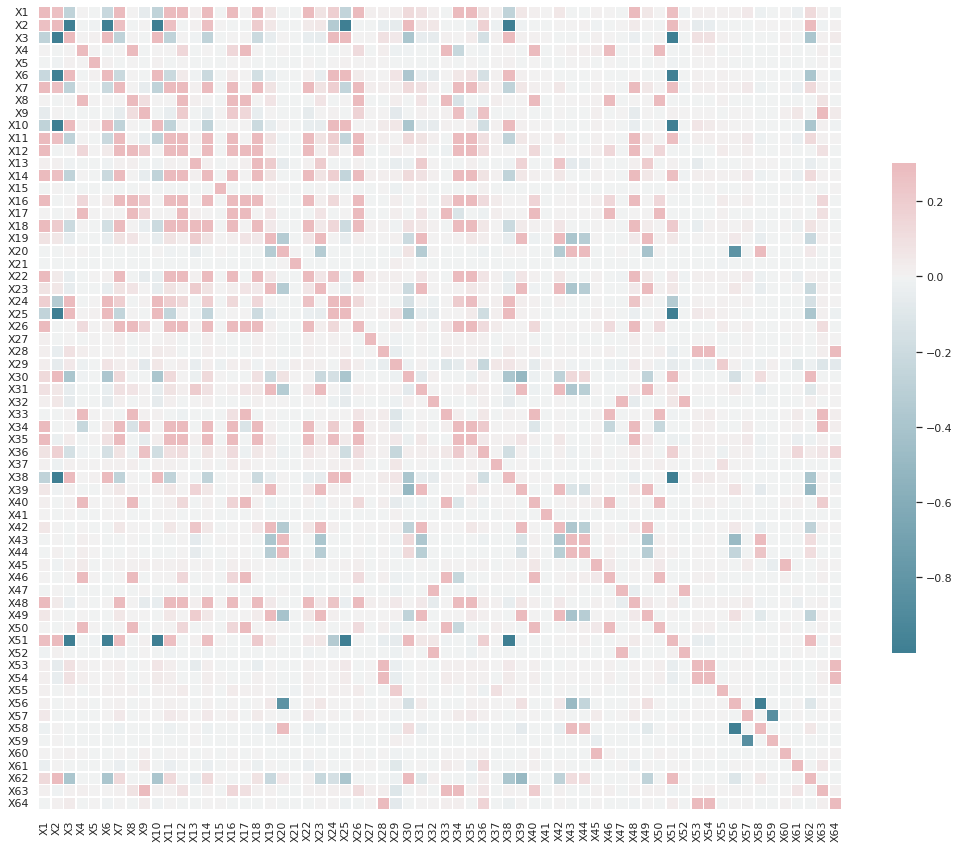

   nrow  ncol  Y=1cnt Y=1rate  rmisscnt  cmisscnt rmissrate  cmissrate
0  9792    65       0     0.0      5023        62   0.51297    0.96875


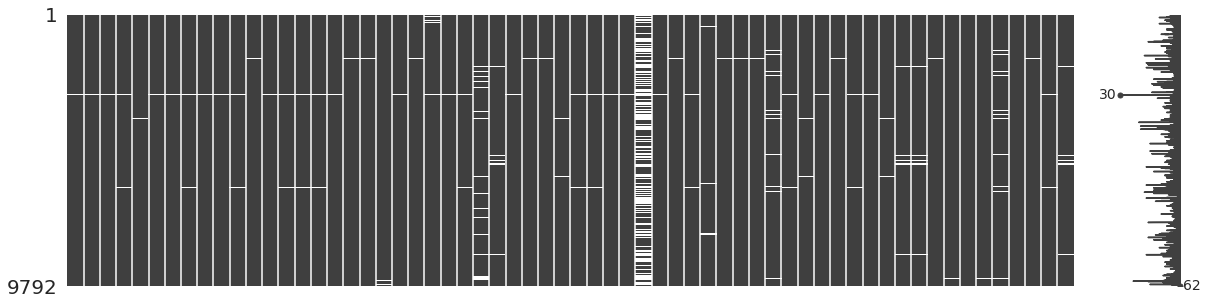

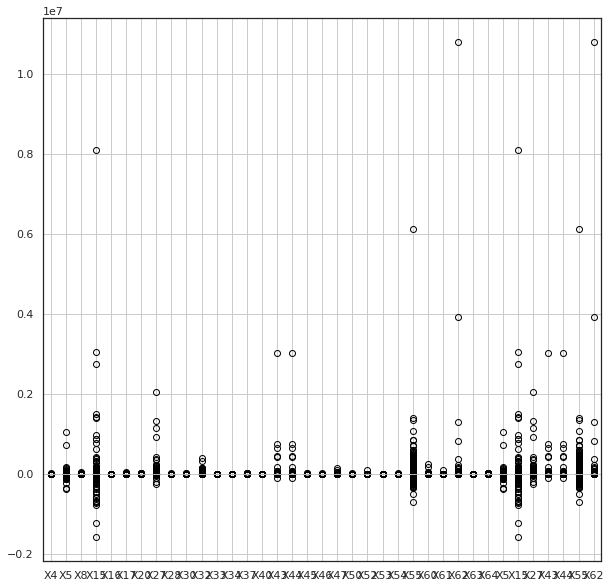

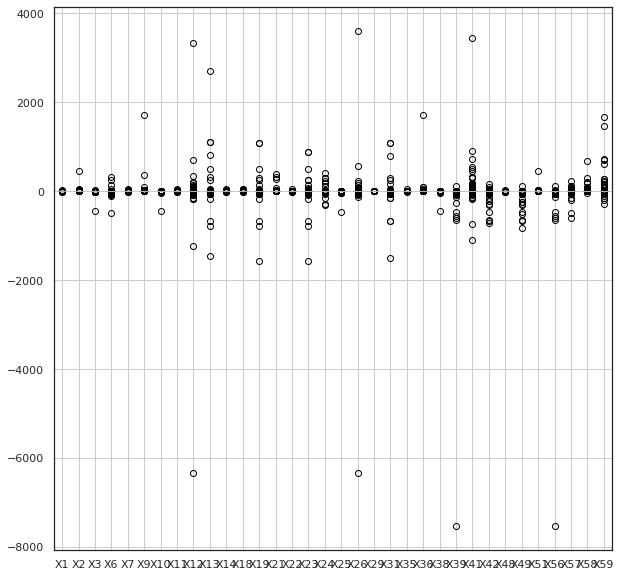

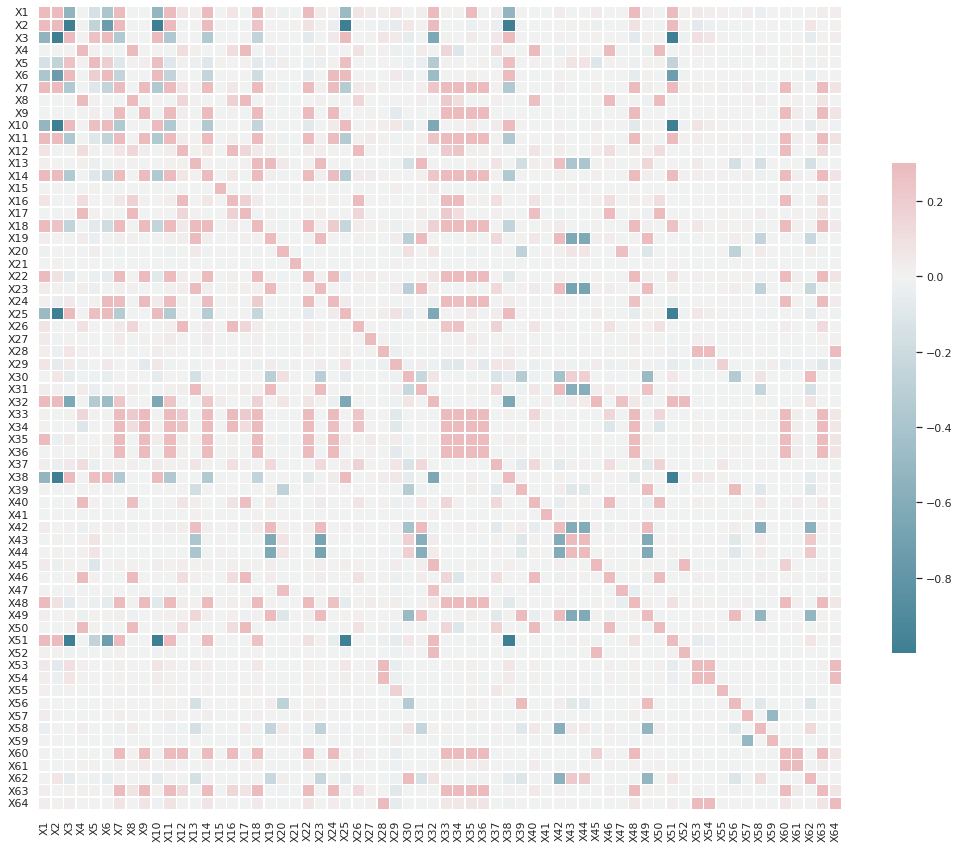

   nrow  ncol  Y=1cnt Y=1rate  rmisscnt  cmisscnt rmissrate  cmissrate
0  5910    65       0     0.0      2879        49   0.48714   0.765625


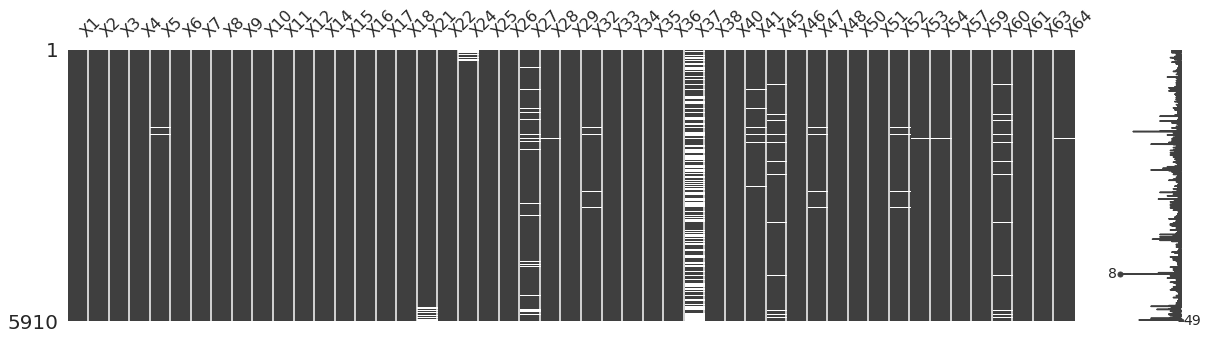

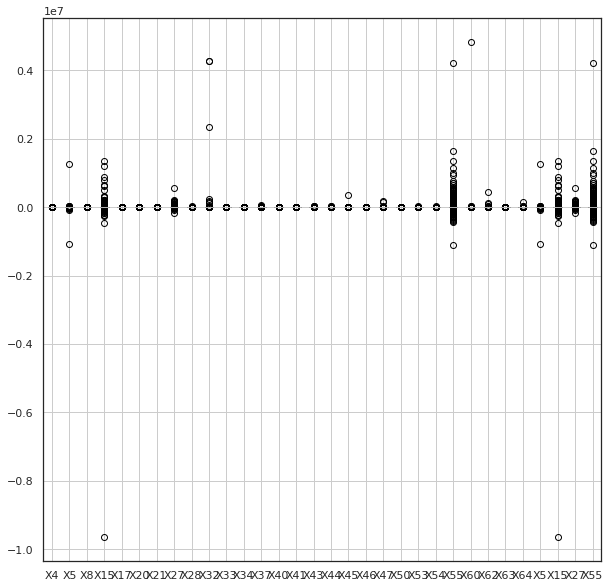

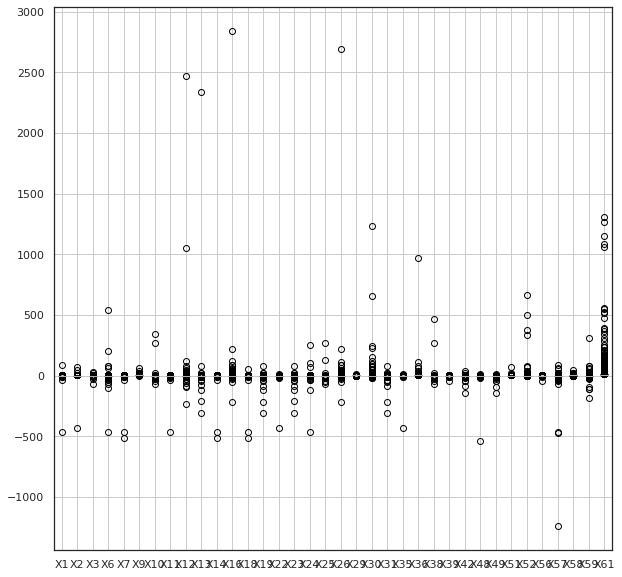

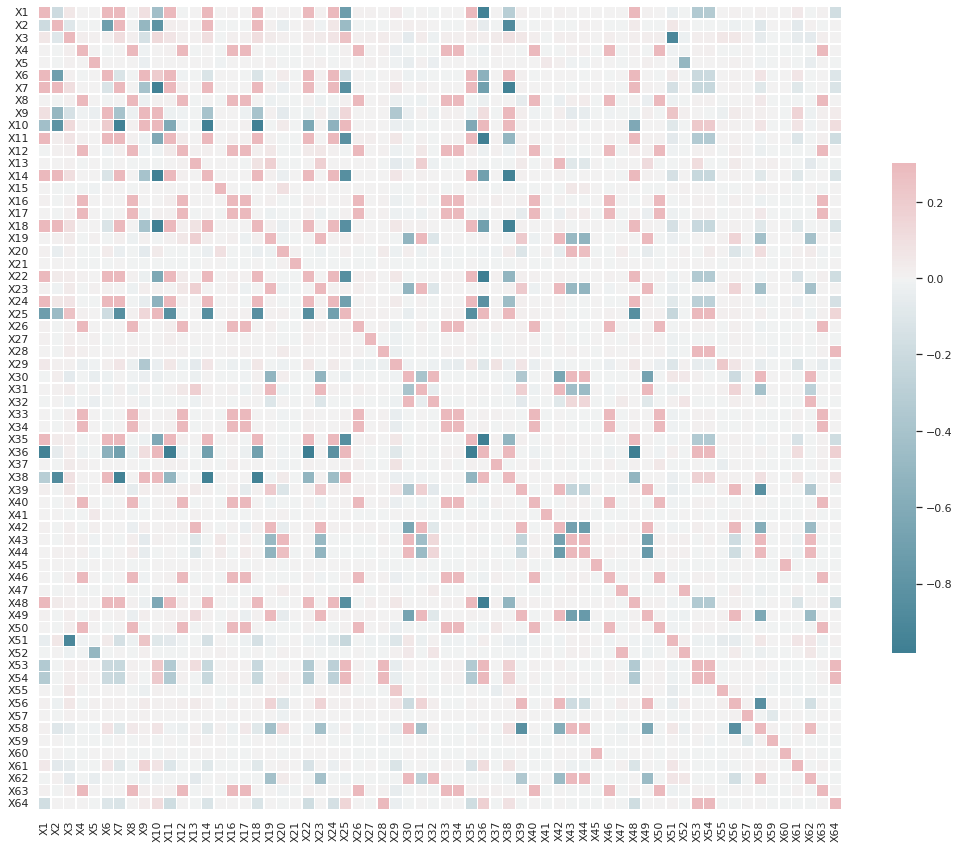

In [7]:
for i in range(5):
    t=describe_data()
    t.setdf(dataframes[i])
    print(t.describe1())
    t.checkmissing()
    t.checkoutlier()
    t.checkcorrelation()

# trainer

In [12]:
class trainer:
    def setdf(self,df):
        self.df=df
        
    def imputemissing(self,method):
        if method == 'mean':
            imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
            imputed_df = imputer.fit_transform(self.df)
        if method == 'knn':
            imputed_df = fancyimpute.KNN(k=100,verbose=True).fit_transform(self.df)
        
        self.df1 = pd.DataFrame(imputed_df,columns=self.df.columns)
        return self.df1
      
    def drop_numerical_outliers(self, z_thresh):
        print('Before dropping outliers: ', self.df1.shape)
        constrains = self.df1.iloc[:,:-1].select_dtypes(include=[np.number]) \
            .apply(lambda x: np.abs(stats.zscore(x)) < z_thresh) \
            .all(axis=1)
        self.df1.drop(self.df1.index[~constrains], inplace=True)
        print('After dropping outliers: ', self.df1.shape)
    
    def split(self,rate):
        y = self.df1.loc[:,"Y"]
        X = self.df1.iloc[:,0:64]
        self.X_train, self.X_test, self.y_train, self.y_test =  train_test_split(X, y, test_size=rate, random_state=33)
        return [self.X_test,self.y_test]
    
    def upsampling_minority(self):
        print('Before upsampling: training data shape', self.X_train.shape, 'test data shape', self.X_test.shape)
        print("Unbalanced training data{}".format({n: v for n, v in zip(['Not Bankrupt', 'Bankrupt'], np.bincount(self.y_train))}))
    
        sm = SMOTE(random_state=10)
        self.X_train, self.y_train = sm.fit_resample(self.X_train, self.y_train)
   
        print('Finished upsampling: training data shape', self.X_train.shape, 'test data shape', self.X_test.shape)
        print("Balanced training data {}".format({n: v for n, v in zip(['Not Bankrupt', 'Bankrupt'], np.bincount(self.y_train))}))
        return [self.X_test,self.y_test]

  

    def training(self,model):
      try:
        if model == "logit":
          params_logit = {'polynomialfeatures__degree': [1,2],
               'logisticregression__C': [0.01, 0.1, 1 ,10,100]}
          pipe_logit = make_pipeline(PolynomialFeatures(include_bias=False), 
                               StandardScaler(), SelectPercentile(), 
                               LogisticRegression(max_iter=1000))
          lsearch = GridSearchCV(estimator=pipe_logit, 
                           scoring='recall', 
                           param_grid=params_logit, 
                           cv=5, 
                           #iid=False, 
                           n_jobs=-1)
          lsearch.fit(self.X_train, self.y_train)
          trainedmodel = lsearch.best_estimator_
          print('Best parameters: ', lsearch.best_params_)
          print('Finished training Logistic Regression...')
               
        if model == "xgb":
          cv_params = {'n_estimators':  [i for i in range(100, 400, 100)], 'max_depth':[i for i in range(4,7,1)]}
          other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                             'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

          xgb0 = xgb.XGBClassifier(**other_params)
          gsearch1 = GridSearchCV(estimator=xgb0, param_grid=cv_params, scoring='recall', cv=5, verbose=1, n_jobs=-1)
          gsearch1.fit(self.X_train, self.y_train)
          print('Best parameters: ', gsearch1.best_params_)
          print('Best score: ', gsearch1.best_score_)
            
            #tune min_samples_split and min_samples_leaf
          param_tree2 = {'min_child_weight': [i for i in range(3,7,1)]}
          gsearch2 = GridSearchCV(estimator = gsearch1.best_estimator_, 
                            param_grid = param_tree2, 
                            scoring='recall',
                            n_jobs=-1,
                            #iid=False, 
                            cv=5)
          gsearch2.fit(self.X_train, self.y_train)
          print('Best parameters: ', gsearch2.best_params_)
          print('Best score: ', gsearch2.best_score_)
            
            #tune learning_rate
          param_tree3 = {'learning_rate':[0.01,0.1,0.2]}
          gsearch3 = GridSearchCV(estimator = gsearch2.best_estimator_, 
                            param_grid = param_tree3, 
                            scoring='recall',
                            n_jobs=-1,
                            #iid=False, 
                            cv=5)
          gsearch3.fit(self.X_train, self.y_train)
          print('Best parameters: ', gsearch3.best_params_)
          print('Best score: ', gsearch3.best_score_)                 
    
            # best estimator
          trainedmodel = gsearch3.best_estimator_
    
            # plot result tree and feature importance

            #dot_data = StringIO()

            #dot_data=export_graphviz(trainedmodel.estimators_[0][0], 
            #                     out_file=None,
            #                     filled = True, 
            #                    rounded = True,
            #                    special_characters = True)
            #display(graphviz.Source(dot_data))
          print('Show Feature Importance:\n')
            
          feat_imp = pd.Series(data=trainedmodel.feature_importances_, index=self.X_train.columns).sort_values(ascending=False)
          plt.figure()
          f, ax = plt.subplots(figsize=(10, 10))
          feat_imp.plot(kind='bar', title='Feature Importances')
          plt.ylabel('Feature Importance Score')
          plt.show()
            
        if model == 'nn':
          def nn_3layers(n_hiddens=[64,16], input_size=64):
            nn_model = Sequential([ layers.Dense(n_hiddens[0], activation=tf.nn.relu, name="hidden1", input_shape=(input_size,)),
            layers.Dense(n_hiddens[1], activation=tf.nn.relu, name='hidden2'),
            layers.Dense(1, activation=tf.nn.sigmoid, name="outputs")
                             ]
                            )
            nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
            return nn_model
            
          nn_model = KerasClassifier(build_fn=nn_3layers)
          pipe_nn = make_pipeline(PolynomialFeatures(include_bias=False), StandardScaler(), nn_model)
          param_nn = [{'polynomialfeatures__degree': [1],
                'kerasclassifier__input_size': [len(PolynomialFeatures(1, include_bias=False).fit(self.X_train).get_feature_names())],
                'kerasclassifier__n_hiddens': [[64, 16], [32, 16]],
                'kerasclassifier__epochs': [10,20],
                'kerasclassifier__batch_size': [64, 128]
               },
                {'polynomialfeatures__degree': [2],
                'kerasclassifier__input_size': [len(PolynomialFeatures(2, include_bias=False).fit(self.X_train).get_feature_names())],
                'kerasclassifier__n_hiddens': [[64, 16], [32, 16]],
                'kerasclassifier__epochs': [10,20],
                'kerasclassifier__batch_size': [64, 128]
               }]
          nsearch = GridSearchCV(estimator=pipe_nn, 
                        param_grid=param_nn,
                        scoring='recall',
                        n_jobs=1, 
                        #iid=False,
                        cv=3)

          nsearch.fit(self.X_train, self.y_train)
          print('Best parameters: ', nsearch.best_params_)
    
          trainedmodel = nsearch.best_estimator_
      except Exception as e:
        print(model,'存在异常')  
      else:
        return trainedmodel           

# Logistic regression

In [15]:
col_map = plt.get_cmap('Paired')

def ShowEvaluation(models, curve, show_plots, X_test, y_test):
    final_report = pd.DataFrame(index=['1', '2', '3','4','5'], 
                            columns=['accuracy', 'precision', 'recall', 'f1',  'f1_macro','auc'])
    
    for i in range(len(models)):
        model = models[i]
        name = final_report.index[i]
        report = pd.DataFrame(classification_report(y_test[i], model.predict(X_test[i]), output_dict=True)).transpose()
        precision, recall, thresholds = curve(y_test[i], model.predict_proba(X_test[i])[:,1])
        final_report.loc[name, :] = [report.loc['accuracy', 'support'], 
                                 report.loc['1.0', 'precision'],
                                 report.loc['1.0', 'recall'],
                                 report.loc['1.0', 'f1-score'],
                                 report.loc['macro avg', 'f1-score'],
                                 auc(precision, recall)
                                    ]
        
    final_report.transpose().plot.bar(rot=0,color=col_map.colors,figsize=(10, 5))
    plt.legend(loc='best')
        
    print(final_report)

In [13]:
logitmodels=[0]*5
logittestx=[0]*5
logittesty=[0]*5
for i in range(5):

    t=trainer()
    t.setdf(dataframes[i])
    t.imputemissing("mean")
    t.drop_numerical_outliers(3)
    t.split(0.2)
    logittestx[i],logittesty[i]=t.upsampling_minority()
    logitmodels[i]=t.training("logit")


Before dropping outliers:  (7027, 65)
After dropping outliers:  (6706, 65)
Before upsampling: training data shape (5364, 64) test data shape (1342, 64)
Unbalanced training data{'Not Bankrupt': 5153, 'Bankrupt': 211}
Finished upsampling: training data shape (10306, 64) test data shape (1342, 64)
Balanced training data {'Not Bankrupt': 5153, 'Bankrupt': 5153}
Best parameters:  {'logisticregression__C': 100, 'polynomialfeatures__degree': 2}
Finished training Logistic Regression...
Before dropping outliers:  (10173, 65)
After dropping outliers:  (9804, 65)
Before upsampling: training data shape (7843, 64) test data shape (1961, 64)
Unbalanced training data{'Not Bankrupt': 7529, 'Bankrupt': 314}
Finished upsampling: training data shape (15058, 64) test data shape (1961, 64)
Balanced training data {'Not Bankrupt': 7529, 'Bankrupt': 7529}
Best parameters:  {'logisticregression__C': 100, 'polynomialfeatures__degree': 2}
Finished training Logistic Regression...
Before dropping outliers:  (10503

   accuracy precision    recall        f1  f1_macro       auc
1  0.964978  0.515152  0.354167  0.419753  0.700848  0.799234
2  0.951045   0.28125  0.264706  0.272727  0.623699  0.767922
3  0.927536  0.289062  0.406593    0.3379  0.649785  0.799019
4  0.935484  0.337349  0.301075  0.318182  0.642161  0.738716
5  0.949821  0.613636  0.409091  0.490909  0.732259  0.807013


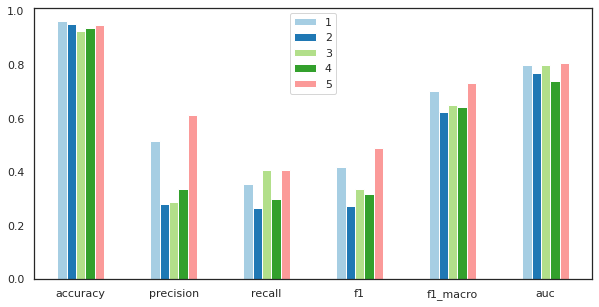

In [16]:
ShowEvaluation(logitmodels,roc_curve,True,logittestx,logittesty)

In [17]:
def feature_coef(model):
    for i in range(len(model)):
        length=model[i][:-1].get_feature_names_out().shape[0]
        coef=model[i].named_steps['logisticregression'].coef_.reshape(length)
        sortdf=pd.DataFrame(np.c_[model[i][:-1].get_feature_names_out(),coef],columns=['name','coef']).sort_values(by='coef',ascending=True)
        print(sortdf.tail(10),sortdf.head(10))
feature_coef(logitmodels)

        name       coef
44    X3 X17   7.564651
158  X25 X26   7.606874
3         X4   8.589124
143  X20 X26   8.610465
184  X33 X38    9.75787
6         X8  12.261722
180  X32 X33  18.471555
34    X2 X17  63.673482
203  X44 X61  78.694571
214  X62 X63  87.862556         name       coef
166  X26 X38 -11.949826
125  X16 X20 -11.101569
23     X1 X4   -8.85294
22       X63  -8.731863
181  X32 X35   -8.27952
133  X17 X38  -7.672761
186  X33 X52  -7.646512
18       X46  -7.283321
160  X25 X33  -7.049508
90    X9 X26  -6.407698
        name        coef
15       X35   11.907238
148  X20 X26   12.232877
101  X11 X50   12.665117
106  X12 X36   14.561969
124  X16 X24   16.349046
192  X33 X51   23.795425
53    X4 X51   27.294168
110  X13 X36   40.852528
210  X44 X61   47.813369
32    X2 X17  145.944948         name       coef
2         X3 -37.707223
17       X51 -30.831819
211  X51 X63 -26.250462
145  X19 X36 -25.953186
31    X2 X16 -19.024661
28    X1 X50 -15.850551
164  X24 X26 -14.014634
162  

# XGBOOST

Before dropping outliers:  (7027, 65)
After dropping outliers:  (6706, 65)
Before upsampling: training data shape (5364, 64) test data shape (1342, 64)
Unbalanced training data{'Not Bankrupt': 5153, 'Bankrupt': 211}
Finished upsampling: training data shape (10306, 64) test data shape (1342, 64)
Balanced training data {'Not Bankrupt': 5153, 'Bankrupt': 5153}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters:  {'max_depth': 5, 'n_estimators': 300}
Best score:  0.9930159238367876
Best parameters:  {'min_child_weight': 3}
Best score:  0.9918521936474155
Best parameters:  {'learning_rate': 0.1}
Best score:  0.9918521936474155
Show Feature Importance:



<Figure size 432x288 with 0 Axes>

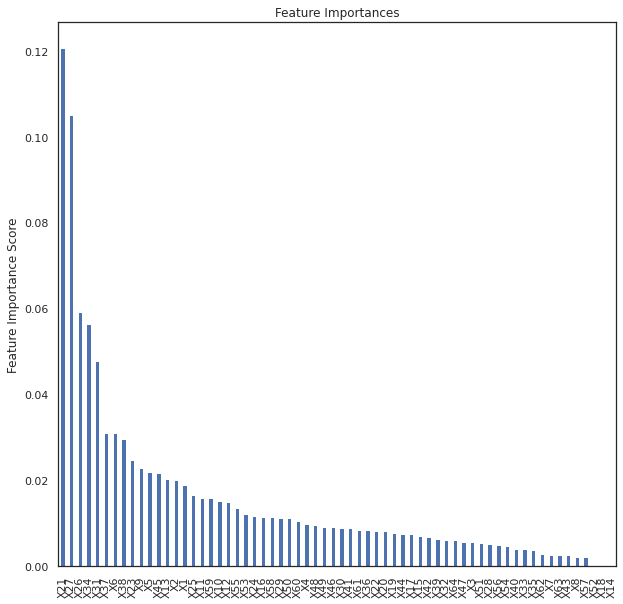

Before dropping outliers:  (10173, 65)
After dropping outliers:  (9804, 65)
Before upsampling: training data shape (7843, 64) test data shape (1961, 64)
Unbalanced training data{'Not Bankrupt': 7529, 'Bankrupt': 314}
Finished upsampling: training data shape (15058, 64) test data shape (1961, 64)
Balanced training data {'Not Bankrupt': 7529, 'Bankrupt': 7529}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters:  {'max_depth': 6, 'n_estimators': 300}
Best score:  0.9933598055176857
Best parameters:  {'min_child_weight': 3}
Best score:  0.9924301906438476
Best parameters:  {'learning_rate': 0.1}
Best score:  0.9924301906438476
Show Feature Importance:



<Figure size 432x288 with 0 Axes>

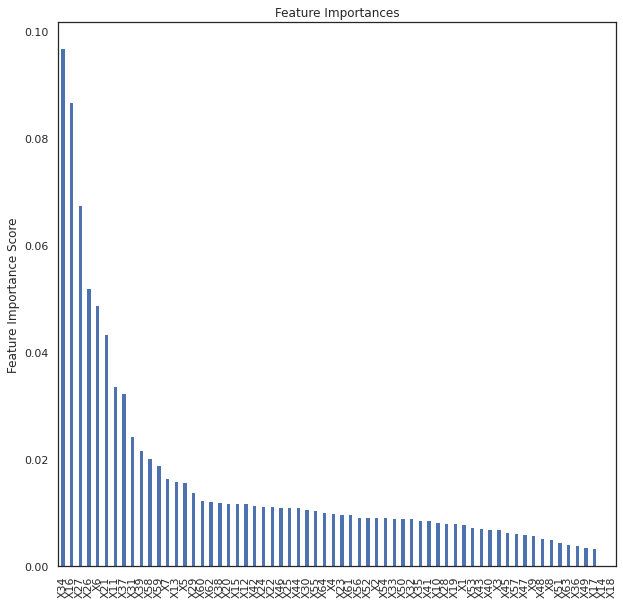

Before dropping outliers:  (10503, 65)
After dropping outliers:  (10001, 65)
Before upsampling: training data shape (8000, 64) test data shape (2001, 64)
Unbalanced training data{'Not Bankrupt': 7620, 'Bankrupt': 380}
Finished upsampling: training data shape (15240, 64) test data shape (2001, 64)
Balanced training data {'Not Bankrupt': 7620, 'Bankrupt': 7620}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters:  {'max_depth': 6, 'n_estimators': 300}
Best score:  0.9896325459317585
Best parameters:  {'min_child_weight': 5}
Best score:  0.988451443569554
Best parameters:  {'learning_rate': 0.2}
Best score:  0.9887139107611549
Show Feature Importance:



<Figure size 432x288 with 0 Axes>

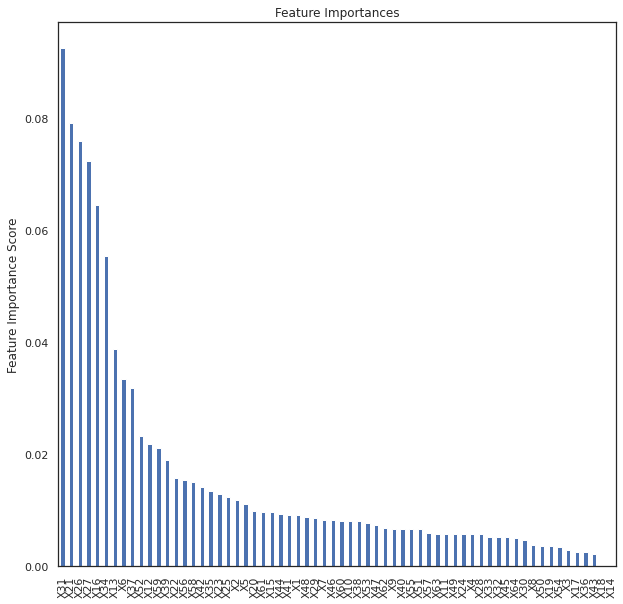

Before dropping outliers:  (9792, 65)
After dropping outliers:  (9297, 65)
Before upsampling: training data shape (7437, 64) test data shape (1860, 64)
Unbalanced training data{'Not Bankrupt': 7056, 'Bankrupt': 381}
Finished upsampling: training data shape (14112, 64) test data shape (1860, 64)
Balanced training data {'Not Bankrupt': 7056, 'Bankrupt': 7056}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters:  {'max_depth': 6, 'n_estimators': 300}
Best score:  0.9926294412778592
Best parameters:  {'min_child_weight': 3}
Best score:  0.9916372371672993
Best parameters:  {'learning_rate': 0.2}
Best score:  0.9920624675003964
Show Feature Importance:



<Figure size 432x288 with 0 Axes>

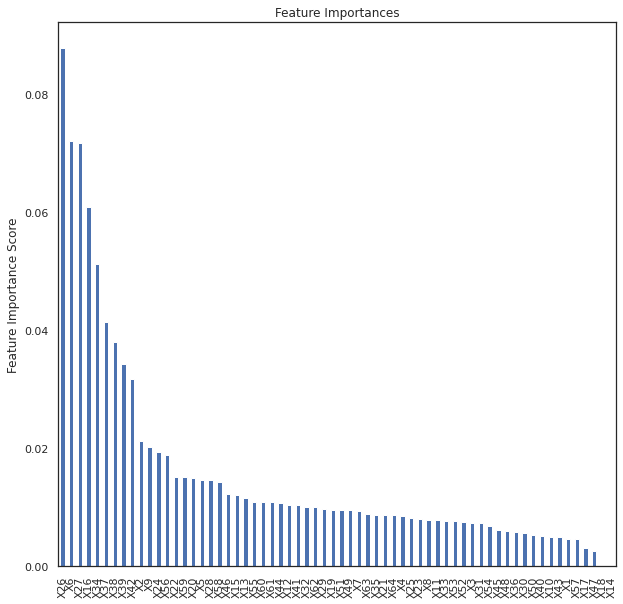

Before dropping outliers:  (5910, 65)
After dropping outliers:  (5576, 65)
Before upsampling: training data shape (4460, 64) test data shape (1116, 64)
Unbalanced training data{'Not Bankrupt': 4173, 'Bankrupt': 287}
Finished upsampling: training data shape (8346, 64) test data shape (1116, 64)
Balanced training data {'Not Bankrupt': 4173, 'Bankrupt': 4173}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters:  {'max_depth': 6, 'n_estimators': 300}
Best score:  0.9918539898620026
Best parameters:  {'min_child_weight': 3}
Best score:  0.9904174385042864
Best parameters:  {'learning_rate': 0.1}
Best score:  0.9904174385042864
Show Feature Importance:



<Figure size 432x288 with 0 Axes>

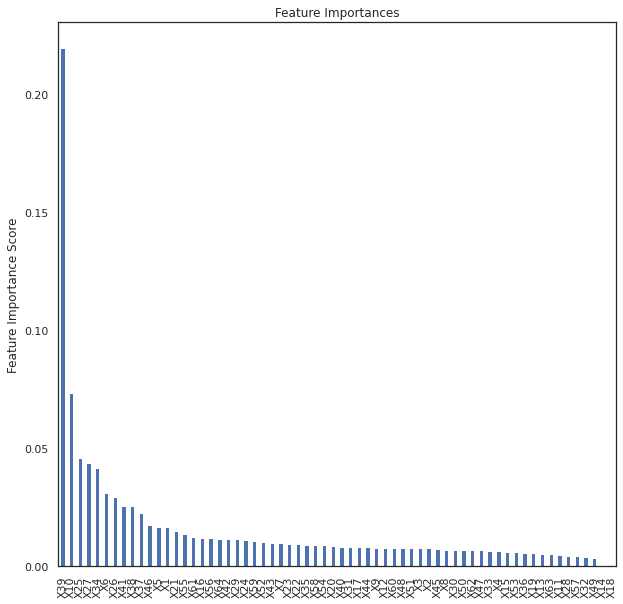

In [193]:
xgbmodels=[0]*5
xgbtestx=[0]*5
xgbtesty=[0]*5
for i in range(5):

    t=trainer()
    t.setdf(dataframes[i])
    t.imputemissing("mean")
    t.drop_numerical_outliers(3)
    t.split(0.2)
    xgbtestx[i],xgbtesty[i]=t.upsampling_minority()
    xgbmodels[i]=t.training("xgb")

   accuracy precision    recall        f1  f1_macro       auc
1  0.985842  0.837209      0.75  0.791209  0.891941  0.985478
2  0.977053  0.716981  0.558824  0.628099   0.80813  0.937261
3  0.967016  0.686567  0.505495  0.582278  0.782554  0.927777
4   0.96828  0.774194  0.516129  0.619355  0.801403  0.924956
5  0.965054  0.736842  0.636364  0.682927  0.832217  0.957576


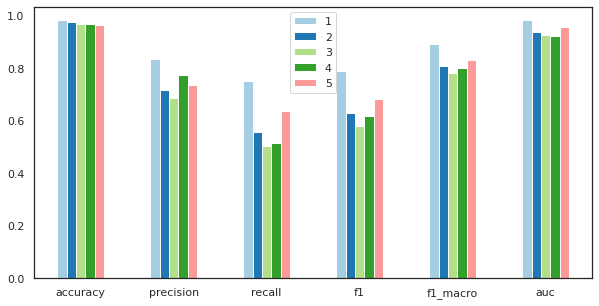

In [195]:
ShowEvaluation(xgbmodels,roc_curve,True,xgbtestx,xgbtesty)

# NN

In [ ]:
nnmodels=[0]*5
nntestx=[0]*5
nntesty=[0]*5
for i in range(5):

    t=trainer()
    t.setdf(dataframes[i])
    t.imputemissing("mean")
    t.drop_numerical_outliers(3)
    t.split(0.2)
    nntestx[i],nntesty[i]=t.upsampling_minority()
    nnmodels[i]=t.training("nn")

In [ ]:
ShowEvaluation(nnmodels,roc_curve,True,nntestx,nntesty)

# model compare

In [184]:
def plot_curve(model, model_name, marker, decision_function, curve,testy,testX):
  if decision_function:
    precision, recall, thresholds = curve(testy, model.decision_function(testX))
    close = np.argmin(np.abs(thresholds))
  else:
    precision, recall, thresholds = curve(testy, model.predict_proba(testX)[:,1])
    close = np.argmin(np.abs(thresholds - 0.5))
    roc_auc_logis = auc(precision, recall)
    plt.plot(precision, recall, label=model_name+'AUC = %0.2f' % roc_auc_logis)
    plt.plot(precision[close], recall[close], marker, c='k', markersize=10, 
                label="threshold "+model_name, fillstyle='none', mew=2)

def CompareModels(models, curve, show_plots, X_test, y_test):
  
    
  for i in range(len(models)):
    final_report = pd.DataFrame(index=['lr', 'gbm', 'nn'], 
                            columns=['accuracy', 'precision', 'recall', 'f1',  'f1_macro'])
    for j in range(len(comparemodels[0])):
      model = models[i][j]
      name = final_report.index[j]
      report = pd.DataFrame(classification_report(y_test[i], model.predict(X_test[i]), output_dict=True)).transpose()
      final_report.loc[name, :] = [report.loc['accuracy', 'support'], 
                                 report.loc['1.0', 'precision'],
                                 report.loc['1.0', 'recall'],
                                 report.loc['1.0', 'f1-score'],
                                 report.loc['macro avg', 'f1-score']]
    final_report.transpose().plot.bar(rot=0,color=col_map.colors,figsize=(10, 5))
    plt.legend(loc='best')
    print("Model Comparison Report:\n", final_report)
    
       
    # roc_auc plot
  
    if show_plots:
      plt.figure(figsize=(10, 5))
      plt.title('Curve')
      plot_curve(models[i][0], 'lr', 'o', False, curve,y_test[i],X_test[i])
      plot_curve(models[i][1], 'xgb', 'D', False, curve,y_test[i],X_test[i])
      plot_curve(models[i][2], 'nn', '*', False, curve,y_test[i],X_test[i])
      plt.legend()
      plt.show()

Before dropping outliers:  (9792, 65)
After dropping outliers:  (9297, 65)
Before upsampling: training data shape (7437, 64) test data shape (1860, 64)
Unbalanced training data{'Not Bankrupt': 7056, 'Bankrupt': 381}
Finished upsampling: training data shape (14112, 64) test data shape (1860, 64)
Balanced training data {'Not Bankrupt': 7056, 'Bankrupt': 7056}
Best parameters:  {'logisticregression__C': 100, 'polynomialfeatures__degree': 2}
Finished training Logistic Regression...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters:  {'max_depth': 6, 'n_estimators': 300}
Best score:  0.9926294412778592
Best parameters:  {'min_child_weight': 3}
Best score:  0.9916372371672993
Best parameters:  {'learning_rate': 0.2}
Best score:  0.9920624675003964
Show Feature Importance:



<Figure size 432x288 with 0 Axes>

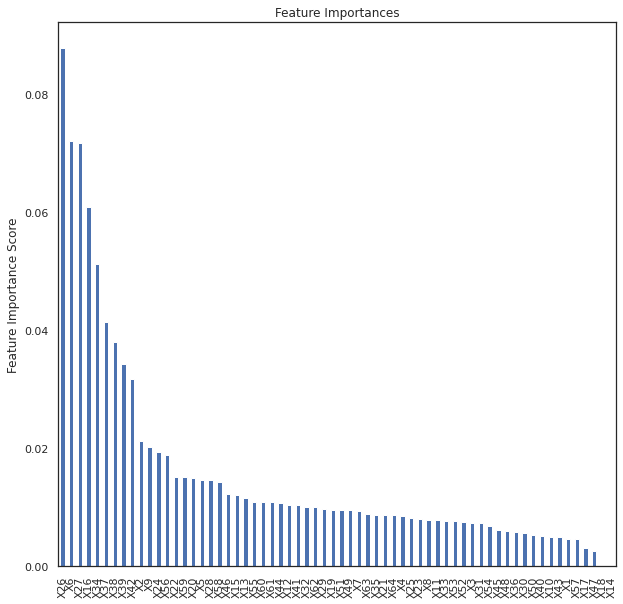

Epoch 1/10
147/147 [==============================] - 1s 3ms/step - loss: 0.5043 - acc: 0.7910
Epoch 2/10
147/147 [==============================] - 0s 3ms/step - loss: 0.4080 - acc: 0.8400
Epoch 3/10
147/147 [==============================] - 0s 3ms/step - loss: 0.3514 - acc: 0.8656
Epoch 4/10
147/147 [==============================] - 0s 3ms/step - loss: 0.3037 - acc: 0.8901
Epoch 5/10
147/147 [==============================] - 0s 3ms/step - loss: 0.2634 - acc: 0.9034
Epoch 6/10
147/147 [==============================] - 0s 2ms/step - loss: 0.2326 - acc: 0.9204
Epoch 7/10
147/147 [==============================] - 0s 3ms/step - loss: 0.2051 - acc: 0.9280
Epoch 8/10
147/147 [==============================] - 0s 2ms/step - loss: 0.1824 - acc: 0.9386
Epoch 9/10
147/147 [==============================] - 0s 3ms/step - loss: 0.1640 - acc: 0.9466
Epoch 10/10
147/147 [==============================] - 0s 3ms/step - loss: 0.1514 - acc: 0.9489
Epoch 1/10
147/147 [=============================

<Figure size 432x288 with 0 Axes>

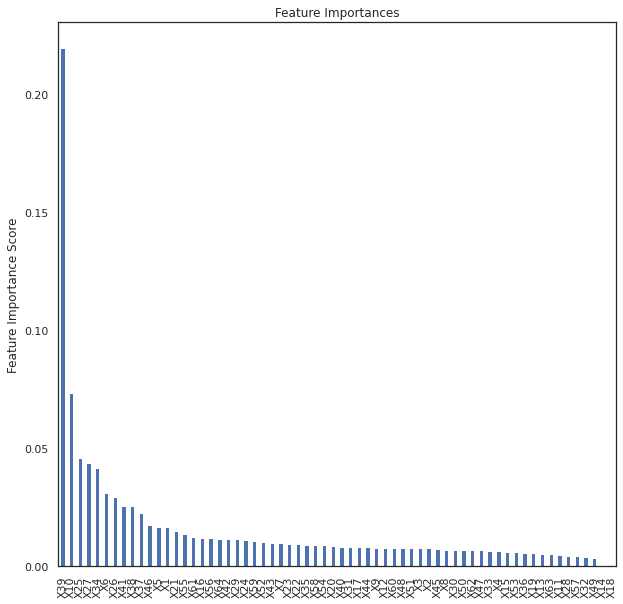

Epoch 1/10
87/87 [==============================] - 1s 3ms/step - loss: 0.4699 - acc: 0.8037
Epoch 2/10
87/87 [==============================] - 0s 3ms/step - loss: 0.3748 - acc: 0.8472
Epoch 3/10
87/87 [==============================] - 0s 3ms/step - loss: 0.3267 - acc: 0.8674
Epoch 4/10
87/87 [==============================] - 0s 3ms/step - loss: 0.2893 - acc: 0.8893
Epoch 5/10
87/87 [==============================] - 0s 3ms/step - loss: 0.2537 - acc: 0.9098
Epoch 6/10
87/87 [==============================] - 0s 3ms/step - loss: 0.2212 - acc: 0.9242
Epoch 7/10
87/87 [==============================] - 0s 3ms/step - loss: 0.1939 - acc: 0.9355
Epoch 8/10
87/87 [==============================] - 0s 3ms/step - loss: 0.1704 - acc: 0.9461
Epoch 9/10
87/87 [==============================] - 0s 3ms/step - loss: 0.1506 - acc: 0.9536
Epoch 10/10
87/87 [==============================] - 0s 3ms/step - loss: 0.1336 - acc: 0.9615
Epoch 1/10
87/87 [==============================] - 1s 3ms/step - los

In [191]:
comparemodels=[[0]*3]*5
testx=[0]*5
testy=[0]*5
for i in range(5):

    t=trainer()
    t.setdf(dataframes[i])
    t.imputemissing("mean")
    t.drop_numerical_outliers(3)
    t.split(0.2)
    testx[i],testy[i]=t.upsampling_minority()
    comparemodels[i][0]=t.training("logit")
    comparemodels[i][1]=t.training("xgb")
    comparemodels[i][2]=t.training("nn")

Model Comparison Report:
      accuracy precision    recall        f1  f1_macro
lr   0.928495       0.3  0.322581  0.310881  0.636586
gbm  0.905914   0.29703  0.645161   0.40678  0.677842
nn   0.934409  0.373913  0.462366  0.413462  0.689362


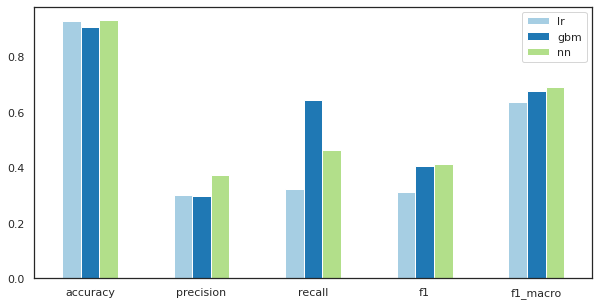

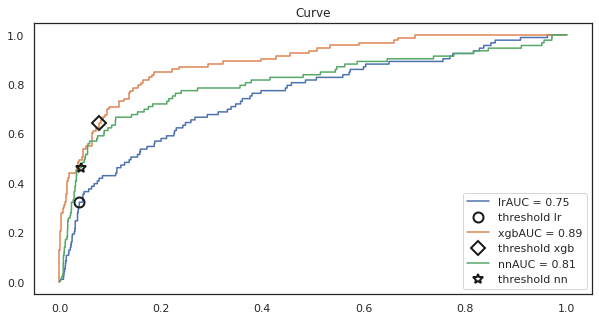

Model Comparison Report:
      accuracy precision    recall        f1  f1_macro
lr   0.949821  0.613636  0.409091  0.490909  0.732259
gbm  0.965054  0.736842  0.636364  0.682927  0.832217
nn   0.957885  0.650794  0.621212  0.635659  0.806655


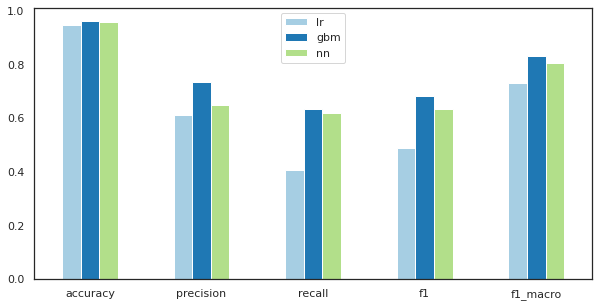

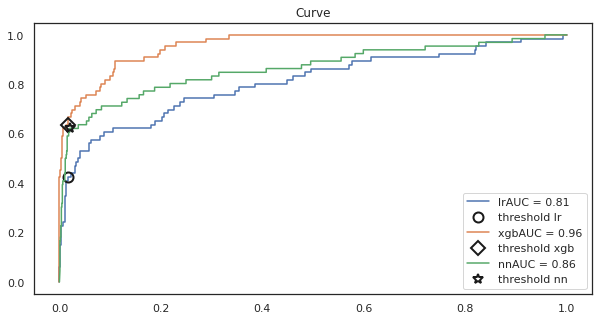

In [192]:
CompareModels(comparemodels,roc_curve,True,testx,testy)